# Data

In [3]:
import ast
import json
import requests
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import StrMethodFormatter
from matplotlib.dates import DateFormatter
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
from sklearn import metrics
from sklearn.metrics import mean_absolute_error

In [4]:
# USDC: baseCurrency:  "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48"
# USDT: baseCurrency:  "0xdac17f958d2ee523a2206206994597c13d831ec7"
# quoteCurrency:  "0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2"

# A simple function to use requests.post to make the API call.
def run_query(query):  
    headers = {'X-API-KEY': 'BQYjLXSsm32NnV6FM4eudu9xYt2L3AsW'}
    request = requests.post('https://graphql.bitquery.io/',
                            json={'query': query}, headers=headers)
    if request.status_code == 200:
        return request.json()
    else:
        raise Exception('Query failed and return code is {}.      {}'.format(request.status_code,
                        query))

# The GraphQL query
query = """
query
{
  ethereum(network: ethereum) {
    dexTrades(
      options: {limit: 100000, asc: "timeInterval.minute"}
      date: {since: "2021-04-21"}
      exchangeName: {is: "Uniswap"}
      baseCurrency: {is: "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48"}
      quoteCurrency: {is: "0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2"}
    ) {
      timeInterval {
        minute(count: 5)
      }
      baseCurrency {
        symbol
        address
      }
      baseAmount
      quoteCurrency {
        symbol
        address
      }
      quoteAmount
      trades: count
      quotePrice
      maximum_price: quotePrice(calculate: maximum)
      minimum_price: quotePrice(calculate: minimum)
      open_price: minimum(of: block, get: quote_price)
      close_price: maximum(of: block, get: quote_price)
    }
  }
}

"""
# Execute the query
result = run_query(query)  

#Build dataframe
data=pd.DataFrame(result['data']['ethereum']['dexTrades'])

#Data Cleaning, Feature Engineering
data= data.dropna()

time=[]
for x in range(0, data.shape[0]):
    time.append(data['timeInterval'].iloc[x]['minute'])  
data['timeInterval']= time

data['close_price']= data['close_price'].apply(lambda x: float(x))
data=data.set_index('timeInterval')
data.index=pd.to_datetime(data.index)
print(data.shape)
data.tail(2)

(10298, 10)


,baseCurrency,baseAmount,quoteCurrency,quoteAmount,trades,quotePrice,maximum_price,minimum_price,open_price,close_price
timeInterval,,,,,,,,,,
2021-05-26 18:10:00,"{'symbol': 'USDC', 'address': '0xa0b86991c6218...",237346.821852,"{'symbol': 'WETH', 'address': '0xc02aaa39b223f...",87.357426,29,0.000368,0.000369,0.000366,0.00036591924700446,0.000367
2021-05-26 18:15:00,"{'symbol': 'USDC', 'address': '0xa0b86991c6218...",54494.194885,"{'symbol': 'WETH', 'address': '0xc02aaa39b223f...",20.074273,18,0.000368,0.000369,0.000367,0.0003665890909117055,0.000367


# Model 1: Two-Layer

In [242]:
def train_test_split(df, test_size):
    split = df.shape[0] - int(test_size * df.shape[0])
    train_set = df.iloc[:split]
    test_set = df.iloc[split:]
    return train_set, test_set

train_set, test_set = train_test_split(data, 0.3)


def zero_scaling(df):   
    return df / df.iloc[0] - 1


def sliding_window(df, len_window, zero):   
    window = []
    for a in range(df.shape[0] - len_window):
        sub = df[a: (a + len_window)].copy()
        if zero:
            sub = zero_scaling(sub)
        window.append(sub.values)
    return np.array(window)


def prepare_data(column, len_window, zero):     
    train_data = train_set[[column]]
    test_data = test_set[[column]]  
    
    X_train = sliding_window(train_data, len_window, zero)  
    X_test = sliding_window(test_data, len_window, zero) 
    
    y_train = train_data[column][len_window:].values
    y_test = test_data[column][len_window:].values
    
    if zero:
        y_train = y_train / train_data[column][:-len_window].values - 1
        y_test = y_test / test_data[column][:-len_window].values - 1
        
    return train_data,  test_data, X_train, X_test,  y_train, y_test


train_data,  test_data, X_train, X_test,  y_train, y_test = prepare_data(column='close_price', len_window=5, zero=True)
    
model_1 = Sequential()
model_1.add(LSTM(units=100, input_shape=(X_train.shape[1], X_train.shape[2])) )  
model_1.add(Dropout(0.2))
model_1.add(Dense(units=1 ))  # tedade noroun ha
model_1.add(Activation('linear'))  #activation ra besoorate layer joda add konim natije behtar ast
model_1.compile(loss='mse', optimizer='adam') 

history_1= model_1.fit(X_train, y_train, validation_split=0.1, epochs = 30, batch_size = 32, verbose=1, shuffle=False)

Epoch 1/30
203/203 [==============================] - 5s 11ms/step - loss: 9.2596e-05 - val_loss: 4.3514e-05
Epoch 2/30
203/203 [==============================] - 2s 8ms/step - loss: 3.9615e-05 - val_loss: 3.6363e-05
Epoch 3/30
203/203 [==============================] - 2s 8ms/step - loss: 3.2167e-05 - val_loss: 3.3376e-05
Epoch 4/30
203/203 [==============================] - 2s 8ms/step - loss: 3.0350e-05 - val_loss: 3.2310e-05
Epoch 5/30
203/203 [==============================] - 2s 7ms/step - loss: 2.9581e-05 - val_loss: 3.1654e-05
Epoch 6/30
203/203 [==============================] - 1s 7ms/step - loss: 2.9488e-05 - val_loss: 3.1733e-05
Epoch 7/30
203/203 [==============================] - 2s 8ms/step - loss: 2.9608e-05 - val_loss: 3.1710e-05
Epoch 8/30
203/203 [==============================] - 1s 7ms/step - loss: 2.9701e-05 - val_loss: 3.1751e-05
Epoch 9/30
203/203 [==============================] - 4s 17ms/step - loss: 2.9051e-05 - val_loss: 3.1548e-05
Epoch 10/30
203/203 [=====

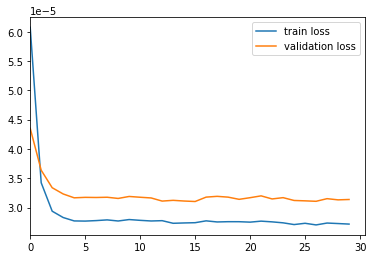

In [243]:
plt.figure(figsize=(6,4))
plt.plot(history_1.history["loss"], label= "train loss")
plt.plot(history_1.history["val_loss"], label= "validation loss")
plt.xlim(0)
plt.legend()
plt.show()

In [247]:
prediction_1=model_1.predict(X_test).squeeze()
predicted_1= pd.DataFrame(data=(prediction_1 + 1) * (test_data['close_price'][:-5].values) ,  index=test_data[5:].index ,columns=['predicted_'+'close_price'] )  
data_final_1= test_set[['close_price']]
data_final_1= data_final_1.join(predicted_1)
data_final_1[5:]

,close_price,predicted_close_price
timeInterval,,
2021-05-16 01:10:00,0.000261,0.000263
2021-05-16 01:15:00,0.000261,0.000261
2021-05-16 01:20:00,0.000261,0.000261
2021-05-16 01:25:00,0.000263,0.000261
2021-05-16 01:30:00,0.000262,0.000262
...,...,...
2021-05-26 17:55:00,0.000365,0.000369
2021-05-26 18:00:00,0.000367,0.000366
2021-05-26 18:05:00,0.000366,0.000367


# Model 2: Five-Layer

In [245]:
def train_test_split(df, test_size):
    split = df.shape[0] - int(test_size * df.shape[0])
    train_set = df.iloc[:split]
    test_set = df.iloc[split:]
    return train_set, test_set

train_set, test_set = train_test_split(data, 0.3)


def zero_scaling(df):   
    return df / df.iloc[0] - 1


def sliding_window(df, len_window, zero):   
    window = []
    for a in range(df.shape[0] - len_window):
        sub = df[a: (a + len_window)].copy()
        if zero:
            sub = zero_scaling(sub)
        window.append(sub.values)
    return np.array(window)


def prepare_data(column, len_window, zero):     
    train_data = train_set[[column]]
    test_data = test_set[[column]]  
    
    X_train = sliding_window(train_data, len_window, zero)  
    X_test = sliding_window(test_data, len_window, zero) 
    
    y_train = train_data[column][len_window:].values
    y_test = test_data[column][len_window:].values
    
    if zero:
        y_train = y_train / train_data[column][:-len_window].values - 1
        y_test = y_test / test_data[column][:-len_window].values - 1
        
    return train_data,  test_data, X_train, X_test,  y_train, y_test

train_data,  test_data, X_train, X_test,  y_train, y_test = prepare_data(column='close_price', len_window=5, zero=True)



# Initialising the LSTM
model_2 = Sequential()
# Adding the first LSTM layer and some Dropout regularisation
model_2.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model_2.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model_2.add(LSTM(units = 50, return_sequences = True))
model_2.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model_2.add(LSTM(units = 50, return_sequences = True))
model_2.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model_2.add(LSTM(units = 50))
model_2.add(Dropout(0.2))
# Adding the output layer
model_2.add(Dense(units = 1))
# Compiling the RNN
model_2.compile(optimizer = 'adam', loss = 'mean_squared_error')

history_2 = model_2.fit(X_train, y_train, validation_split=0.1, epochs = 30, batch_size = 32, verbose=1, shuffle=False)

Epoch 1/30
203/203 [==============================] - 13s 27ms/step - loss: 1.1759e-04 - val_loss: 1.3770e-04
Epoch 2/30
203/203 [==============================] - 4s 20ms/step - loss: 1.0538e-04 - val_loss: 1.3319e-04
Epoch 3/30
203/203 [==============================] - 4s 19ms/step - loss: 1.0584e-04 - val_loss: 1.3370e-04
Epoch 4/30
203/203 [==============================] - 6s 32ms/step - loss: 1.0168e-04 - val_loss: 6.4577e-05
Epoch 5/30
203/203 [==============================] - 4s 20ms/step - loss: 6.7798e-05 - val_loss: 4.2810e-05
Epoch 6/30
203/203 [==============================] - 4s 21ms/step - loss: 3.6660e-05 - val_loss: 3.5455e-05
Epoch 7/30
203/203 [==============================] - 4s 20ms/step - loss: 3.4374e-05 - val_loss: 3.2173e-05
Epoch 8/30
203/203 [==============================] - 4s 21ms/step - loss: 3.2335e-05 - val_loss: 3.2861e-05
Epoch 9/30
203/203 [==============================] - 4s 22ms/step - loss: 3.1684e-05 - val_loss: 3.1414e-05
Epoch 10/30
203/20

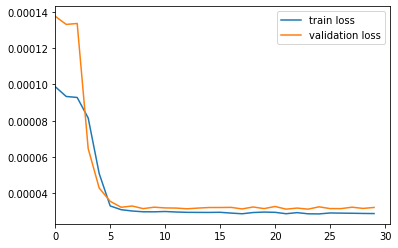

In [246]:
plt.figure(figsize=(6,4))
plt.plot(history_2.history["loss"], label= "train loss")
plt.plot(history_2.history["val_loss"], label= "validation loss")
plt.xlim(0)
plt.legend()
plt.show()

In [248]:
prediction_2=model_2.predict(X_test).squeeze()
predicted_2= pd.DataFrame(data=(prediction_2 + 1) * (test_data['close_price'][:-5].values) ,  index=test_data[5:].index ,columns=['predicted_'+'close_price'] )  
data_final_2= test_set[['close_price']]
data_final_2= data_final_2.join(predicted_2)
data_final_2[5:]

,close_price,predicted_close_price
timeInterval,,
2021-05-16 01:10:00,0.000261,0.000263
2021-05-16 01:15:00,0.000261,0.000261
2021-05-16 01:20:00,0.000261,0.000260
2021-05-16 01:25:00,0.000263,0.000260
2021-05-16 01:30:00,0.000262,0.000262
...,...,...
2021-05-26 17:55:00,0.000365,0.000369
2021-05-26 18:00:00,0.000367,0.000366
2021-05-26 18:05:00,0.000366,0.000366


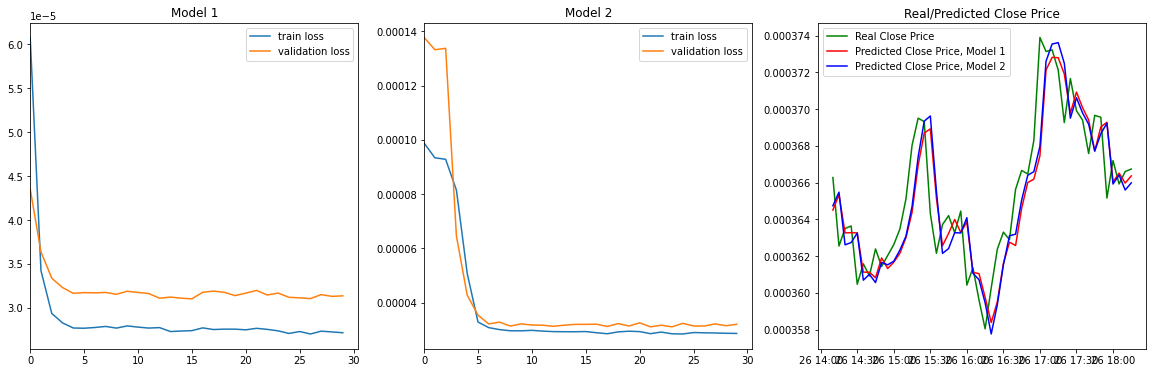

In [249]:
plt.figure(figsize=(20,6))

plt.subplot(1,3,1)

plt.plot(history_1.history["loss"], label= "train loss")
plt.plot(history_1.history["val_loss"], label= "validation loss")
plt.legend()
plt.xlim(0)
plt.title('Model 1')

plt.subplot(1,3,2)
plt.plot(history_2.history["loss"], label= "train loss")
plt.plot(history_2.history["val_loss"], label= "validation loss")
plt.legend()
plt.xlim(0)
plt.title('Model 2')

plt.subplot(1,3,3)
plt.plot(data_final_1[-50:]['close_price'], label="Real Close Price", color='g')
plt.plot(data_final_1[-50:]['predicted_close_price'], label="Predicted Close Price, Model 1", color='r')
plt.plot(data_final_2[-50:]['predicted_close_price'], label="Predicted Close Price, Model 2", color='b')
plt.title('Real/Predicted Close Price')
plt.legend()

plt.show()

In [252]:
print('Model_1, Mean Absolute Error: ', metrics.mean_absolute_error(y_test, prediction_1))    

print('Model_2, Mean Absolute Error: ', metrics.mean_absolute_error(y_test, prediction_2))     

Model_1, Mean Absolute Error:  0.006488472183517306
Model_2, Mean Absolute Error:  0.006572406156460041


# Model_1 

# EMA Bollinger Real & Predicted (span=20, no_of_std=2), Model_1

In [22]:
# Prediction of EMA Bollinger Bands (span=20, no_of_std=2)

def getEMABollingerBands (df):    
    # Calculate EMA & std
    EMA= df['close_price'].ewm(span=20).mean()
    std= df['close_price'].ewm(span=20).std()    
    # Calculate the upper and lower Bearish Bollinger Bands
    df['bearish_lower'] = (EMA - 1.5* 2 * std).abs()
    df['bearish_upper'] = EMA +  2 * std  
    # Calculate the upper and lower Neutral Bollinger Bands
    df['neutral_lower'] = (EMA - 2 * std).abs()
    df['neutral_upper'] = EMA + 2 * std
    # Calculate the upper and lower Bullish Bollinger Bands
    df['bullish_lower'] = (EMA - 2 * std).abs()
    df['bullish_upper'] = EMA + 1.5 * 2 * std
    
    df.dropna(inplace=True)
        
    df=df[['trades','close_price',
           'bearish_lower','bearish_upper', 
           'neutral_lower','neutral_upper',
           'bullish_lower','bullish_upper']]
    return df

copied_data=data.copy()
data_bands=getEMABollingerBands (copied_data)


def train_test_split(df, test_size):
    split = df.shape[0] - int(test_size * df.shape[0])
    train_set = df.iloc[:split]
    test_set = df.iloc[split:]
    return train_set, test_set

train_set, test_set = train_test_split(data_bands, 0.3)

def zero_scaling(df):   
    return df / df.iloc[0] - 1


def sliding_window(df, len_window, zero):   
    window = []
    for a in range(df.shape[0] - len_window):
        sub = df[a: (a + len_window)].copy()
        if zero:
            sub = zero_scaling(sub)
        window.append(sub.values)
    return np.array(window)


def prepare_data(column, len_window, zero):     
    train_data = train_set[[column]]
    test_data = test_set[[column]]  
    
    X_train = sliding_window(train_data, len_window, zero)  
    X_test = sliding_window(test_data, len_window, zero) 
    
    y_train = train_data[column][len_window:].values
    y_test = test_data[column][len_window:].values
    
    if zero:
        y_train = y_train / train_data[column][:-len_window].values - 1
        y_test = y_test / test_data[column][:-len_window].values - 1
        
    return train_data,  test_data, X_train, X_test,  y_train, y_test


data_final_EMA_Bollinger_1= test_set.copy()

for col in test_set.columns[1:]:
    train_data,  test_data, X_train, X_test,  y_train, y_test = prepare_data(column=col, len_window=5, zero=True)
    
    model_1 = Sequential()
    model_1.add(LSTM(units=100, input_shape=(X_train.shape[1], X_train.shape[2])) )  
    model_1.add(Dropout(0.2))
    model_1.add(Dense(units=1 ))  
    model_1.add(Activation('linear'))  
    model_1.compile(loss='mse', optimizer='adam') 

    model_1.fit(X_train, y_train, validation_split=0.1, epochs = 30, batch_size = 32, verbose=1, shuffle=False)
    
    prediction=model_1.predict(X_test).squeeze()
    
    predicted= pd.DataFrame(data=(prediction + 1) * (test_data[col][:-5].values) ,  index=test_data[5:].index ,columns=['predicted_'+col] )            

    data_final_EMA_Bollinger_1= data_final_EMA_Bollinger_1.join(predicted)

data_final_EMA_Bollinger_1;

Epoch 1/30
203/203 [==============================] - 2s 6ms/step - loss: 8.7729e-05 - val_loss: 4.1716e-05
Epoch 2/30
203/203 [==============================] - 1s 5ms/step - loss: 3.8793e-05 - val_loss: 3.5468e-05
Epoch 3/30
203/203 [==============================] - 1s 4ms/step - loss: 3.1520e-05 - val_loss: 3.3236e-05
Epoch 4/30
203/203 [==============================] - 1s 4ms/step - loss: 2.9954e-05 - val_loss: 3.2996e-05
Epoch 5/30
203/203 [==============================] - 1s 4ms/step - loss: 2.9924e-05 - val_loss: 3.1987e-05
Epoch 6/30
203/203 [==============================] - 1s 4ms/step - loss: 3.0013e-05 - val_loss: 3.2137e-05
Epoch 7/30
203/203 [==============================] - 1s 4ms/step - loss: 2.9904e-05 - val_loss: 3.2284e-05
Epoch 8/30
203/203 [==============================] - 1s 4ms/step - loss: 2.9558e-05 - val_loss: 3.0976e-05
Epoch 9/30
203/203 [==============================] - 1s 4ms/step - loss: 2.9479e-05 - val_loss: 3.1409e-05
Epoch 10/30
203/203 [=======

203/203 [==============================] - 1s 4ms/step - loss: 2.4477e-06 - val_loss: 1.7881e-06
Epoch 17/30
203/203 [==============================] - 1s 4ms/step - loss: 2.6764e-06 - val_loss: 1.7020e-06
Epoch 18/30
203/203 [==============================] - 1s 4ms/step - loss: 2.3223e-06 - val_loss: 1.8423e-06
Epoch 19/30
203/203 [==============================] - 1s 4ms/step - loss: 2.6533e-06 - val_loss: 1.5458e-06
Epoch 20/30
203/203 [==============================] - 1s 4ms/step - loss: 2.1249e-06 - val_loss: 1.5051e-06
Epoch 21/30
203/203 [==============================] - 1s 4ms/step - loss: 2.3802e-06 - val_loss: 2.3480e-06
Epoch 22/30
203/203 [==============================] - 1s 4ms/step - loss: 2.7281e-06 - val_loss: 1.6554e-06
Epoch 23/30
203/203 [==============================] - 1s 4ms/step - loss: 2.5022e-06 - val_loss: 1.8845e-06
Epoch 24/30
203/203 [==============================] - 1s 4ms/step - loss: 2.4563e-06 - val_loss: 1.5122e-06
Epoch 25/30
203/203 [==========

203/203 [==============================] - 3s 6ms/step - loss: 3.7917e-05 - val_loss: 9.8438e-06
Epoch 2/30
203/203 [==============================] - 1s 4ms/step - loss: 9.9681e-06 - val_loss: 2.7187e-06
Epoch 3/30
203/203 [==============================] - 1s 4ms/step - loss: 3.7568e-06 - val_loss: 2.3842e-06
Epoch 4/30
203/203 [==============================] - 1s 4ms/step - loss: 3.2165e-06 - val_loss: 2.0330e-06
Epoch 5/30
203/203 [==============================] - 1s 4ms/step - loss: 2.5229e-06 - val_loss: 1.8484e-06
Epoch 6/30
203/203 [==============================] - 1s 4ms/step - loss: 2.4654e-06 - val_loss: 1.6715e-06
Epoch 7/30
203/203 [==============================] - 1s 4ms/step - loss: 2.3371e-06 - val_loss: 1.5147e-06
Epoch 8/30
203/203 [==============================] - 1s 4ms/step - loss: 2.1033e-06 - val_loss: 1.3590e-06
Epoch 9/30
203/203 [==============================] - 1s 4ms/step - loss: 2.0694e-06 - val_loss: 1.3515e-06
Epoch 10/30
203/203 [==================

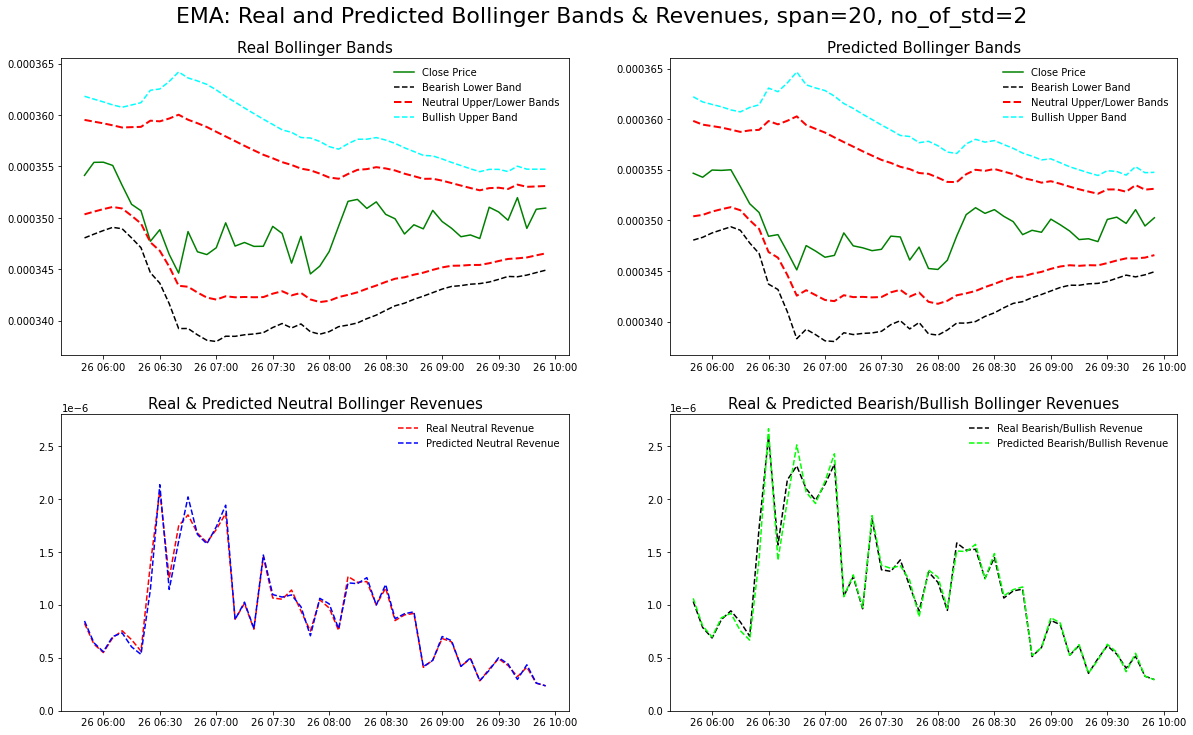

In [141]:
#EMA, Bollinger
test_EMA_Bollinger_1=data_final_EMA_Bollinger_1[-150:-100]

plt.figure(figsize=(20,12))
#Real Bands
plt.subplot(2,2,1)
plt.plot(test_EMA_Bollinger_1['close_price'], label="Close Price", color='g')
plt.plot(test_EMA_Bollinger_1['bearish_lower'], "r--", label="Bearish Lower Band", color='black')
plt.plot(test_EMA_Bollinger_1['neutral_lower'], "r--", color='r', lw=2)
plt.plot(test_EMA_Bollinger_1['neutral_upper'], "r--", label="Neutral Upper/Lower Bands", color='r',lw=2)
plt.plot(test_EMA_Bollinger_1['bullish_upper'], "r--", label="Bullish Upper Band", color='cyan')
plt.legend(loc= 'upper right', frameon=False)
plt.title('Real Bollinger Bands', fontsize=15)
#Predicted Bands
plt.subplot(2,2,2)
plt.plot(test_EMA_Bollinger_1['predicted_close_price'], label="Close Price", color='g' )
plt.plot(test_EMA_Bollinger_1['predicted_bearish_lower'], "r--", label="Bearish Lower Band", color='black')
plt.plot(test_EMA_Bollinger_1['predicted_neutral_lower'], "r--", color='r', lw=2)
plt.plot(test_EMA_Bollinger_1['predicted_neutral_upper'], "r--", label="Neutral Upper/Lower Bands", color='r', lw=2)
plt.plot(test_EMA_Bollinger_1['predicted_bullish_upper'], "r--", label="Bullish Upper Band", color='cyan')
plt.legend(loc= 'upper right', frameon=False)
plt.title('Predicted Bollinger Bands', fontsize=15)

#Compare Real & Predicted Neutral Revenues
plt.subplot(2,2,3)
plt.plot(0.003* (test_EMA_Bollinger_1['neutral_upper'] - test_EMA_Bollinger_1['neutral_lower']) *test_EMA_Bollinger_1['trades'], "r--", label="Real Neutral Revenue", color='r')
plt.plot(0.003* (test_EMA_Bollinger_1['predicted_neutral_upper'] - test_EMA_Bollinger_1['predicted_neutral_lower']) *test_EMA_Bollinger_1['trades'], "r--", label="Predicted Neutral Revenue", color='b')
plt.legend(loc= 'upper right', frameon=False)
plt.ylim(0, 2.8E-6)
plt.title('Real & Predicted Neutral Bollinger Revenues', fontsize=15)

#Compare Real & Predicted Bearish/Bullish Revenue Revenues
plt.subplot(2,2,4)
plt.plot(0.003* (test_EMA_Bollinger_1['bullish_upper'] - test_EMA_Bollinger_1['bullish_lower']) *test_EMA_Bollinger_1['trades'], "r--", label="Real Bearish/Bullish Revenue", color='black')
plt.plot(0.003* (test_EMA_Bollinger_1['predicted_bullish_upper'] - test_EMA_Bollinger_1['predicted_bullish_lower']) *test_EMA_Bollinger_1['trades'], "r--", label="Predicted Bearish/Bullish Revenue", color='lime')
plt.legend(loc= 'upper right', frameon=False)
plt.ylim(0, 2.8E-6)
plt.title('Real & Predicted Bearish/Bullish Bollinger Revenues', fontsize=15)

plt.suptitle('EMA: Real and Predicted Bollinger Bands & Revenues, span=20, no_of_std=2',y=0.94,fontsize=22)
plt.show()

# EMA Non-Bollinger Real & Predicted (span=2, no_of_std=0.9) Model_1

In [25]:
def getEMABollingerBands (df):    
    # Calculate EMA & std
    EMA= df['close_price'].ewm(span=2).mean()
    std= df['close_price'].ewm(span=2).std()    
    # Calculate the upper and lower Bearish Bollinger Bands
    df['bearish_lower'] = (EMA - 1.5* 0.9 * std).abs()
    df['bearish_upper'] = EMA +  0.9 * std  
    # Calculate the upper and lower Neutral Bollinger Bands
    df['neutral_lower'] = (EMA - 0.9 * std).abs()
    df['neutral_upper'] = EMA + 0.9 * std
    # Calculate the upper and lower Bullish Bollinger Bands
    df['bullish_lower'] = (EMA - 0.9 * std).abs()
    df['bullish_upper'] = EMA + 1.5 * 0.9 * std
    
    df.dropna(inplace=True)
    
    
    df=df[['trades','close_price',
           'bearish_lower','bearish_upper', 
           'neutral_lower','neutral_upper',
           'bullish_lower','bullish_upper']]
    
    return df

copied_data=data.copy()
data_bands=getEMABollingerBands (copied_data)


def train_test_split(df, test_size):
    split = df.shape[0] - int(test_size * df.shape[0])
    train_set = df.iloc[:split]
    test_set = df.iloc[split:]
    return train_set, test_set

train_set, test_set = train_test_split(data_bands, 0.3)


def zero_scaling(df):   
    return df / df.iloc[0] - 1


def sliding_window(df, len_window, zero):   
    window = []
    for a in range(df.shape[0] - len_window):
        sub = df[a: (a + len_window)].copy()
        if zero:
            sub = zero_scaling(sub)
        window.append(sub.values)
    return np.array(window)


def prepare_data(column, len_window, zero):     
    train_data = train_set[[column]]
    test_data = test_set[[column]]  
    
    X_train = sliding_window(train_data, len_window, zero)  
    X_test = sliding_window(test_data, len_window, zero) 
    
    y_train = train_data[column][len_window:].values
    y_test = test_data[column][len_window:].values
    
    if zero:
        y_train = y_train / train_data[column][:-len_window].values - 1
        y_test = y_test / test_data[column][:-len_window].values - 1
        
    return train_data,  test_data, X_train, X_test,  y_train, y_test



data_final_EMA_Non_Bollinger_1= test_set.copy()

for col in test_set.columns[1:]:
    train_data,  test_data, X_train, X_test,  y_train, y_test = prepare_data(column=col, len_window=5, zero=True)
    
    model_1 = Sequential()
    model_1.add(LSTM(units=100, input_shape=(X_train.shape[1], X_train.shape[2])) )  
    model_1.add(Dropout(0.2))
    model_1.add(Dense(units=1 ))  
    model_1.add(Activation('linear'))  
    model_1.compile(loss='mse', optimizer='adam') 

    model_1.fit(X_train, y_train, validation_split=0.1, epochs = 30, batch_size = 32, verbose=1, shuffle=False)
    
    prediction=model_1.predict(X_test).squeeze()
        
    predicted= pd.DataFrame(data=(prediction + 1) * (test_data[col][:-5].values) ,  index=test_data[5:].index ,columns=['predicted_'+col] )            

    data_final_EMA_Non_Bollinger_1= data_final_EMA_Non_Bollinger_1.join(predicted)

data_final_EMA_Non_Bollinger_1;

Epoch 1/30
203/203 [==============================] - 3s 6ms/step - loss: 8.0966e-05 - val_loss: 4.1609e-05
Epoch 2/30
203/203 [==============================] - 1s 4ms/step - loss: 3.7232e-05 - val_loss: 3.5497e-05
Epoch 3/30
203/203 [==============================] - 1s 4ms/step - loss: 3.2071e-05 - val_loss: 3.3574e-05
Epoch 4/30
203/203 [==============================] - 1s 4ms/step - loss: 2.9911e-05 - val_loss: 3.2084e-05
Epoch 5/30
203/203 [==============================] - 1s 4ms/step - loss: 3.0080e-05 - val_loss: 3.1393e-05
Epoch 6/30
203/203 [==============================] - 1s 4ms/step - loss: 2.9383e-05 - val_loss: 3.1872e-05
Epoch 7/30
203/203 [==============================] - 1s 4ms/step - loss: 2.9146e-05 - val_loss: 3.2260e-05
Epoch 8/30
203/203 [==============================] - 1s 4ms/step - loss: 2.9792e-05 - val_loss: 3.1647e-05
Epoch 9/30
203/203 [==============================] - 1s 4ms/step - loss: 2.9248e-05 - val_loss: 3.1108e-05
Epoch 10/30
203/203 [=======

203/203 [==============================] - 1s 4ms/step - loss: 1.8563e-05 - val_loss: 1.9007e-05
Epoch 17/30
203/203 [==============================] - 1s 4ms/step - loss: 1.9040e-05 - val_loss: 1.9134e-05
Epoch 18/30
203/203 [==============================] - 1s 4ms/step - loss: 1.9063e-05 - val_loss: 1.9069e-05
Epoch 19/30
203/203 [==============================] - 1s 4ms/step - loss: 1.8533e-05 - val_loss: 1.8922e-05
Epoch 20/30
203/203 [==============================] - 1s 4ms/step - loss: 1.8525e-05 - val_loss: 1.9084e-05
Epoch 21/30
203/203 [==============================] - 1s 4ms/step - loss: 1.9092e-05 - val_loss: 1.8942e-05
Epoch 22/30
203/203 [==============================] - 1s 5ms/step - loss: 1.8588e-05 - val_loss: 1.9145e-05
Epoch 23/30
203/203 [==============================] - 1s 4ms/step - loss: 1.8489e-05 - val_loss: 1.8940e-05
Epoch 24/30
203/203 [==============================] - 1s 4ms/step - loss: 1.8601e-05 - val_loss: 1.8931e-05
Epoch 25/30
203/203 [==========

203/203 [==============================] - 3s 7ms/step - loss: 8.4993e-05 - val_loss: 3.3371e-05
Epoch 2/30
203/203 [==============================] - 1s 4ms/step - loss: 2.9338e-05 - val_loss: 2.4999e-05
Epoch 3/30
203/203 [==============================] - 1s 4ms/step - loss: 2.1521e-05 - val_loss: 2.1934e-05
Epoch 4/30
203/203 [==============================] - 1s 4ms/step - loss: 1.8323e-05 - val_loss: 1.9301e-05
Epoch 5/30
203/203 [==============================] - 1s 4ms/step - loss: 1.6657e-05 - val_loss: 1.7749e-05
Epoch 6/30
203/203 [==============================] - 1s 4ms/step - loss: 1.6088e-05 - val_loss: 1.8043e-05
Epoch 7/30
203/203 [==============================] - 1s 4ms/step - loss: 1.5870e-05 - val_loss: 1.7019e-05
Epoch 8/30
203/203 [==============================] - 1s 4ms/step - loss: 1.5750e-05 - val_loss: 1.6823e-05
Epoch 9/30
203/203 [==============================] - 1s 4ms/step - loss: 1.6108e-05 - val_loss: 1.6559e-05
Epoch 10/30
203/203 [==================

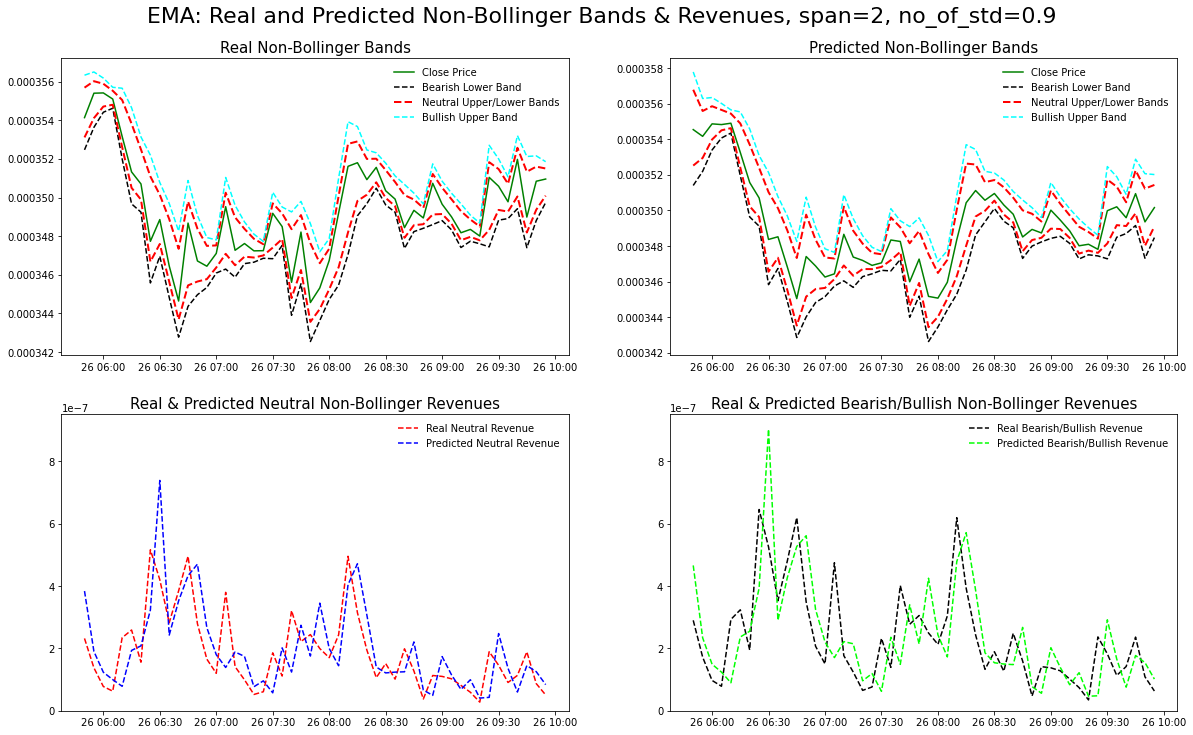

In [140]:
#EMA, NonBollinger
test_EMA_Non_Bollinger_1=data_final_EMA_Non_Bollinger_1[-150:-100]

plt.figure(figsize=(20,12))
#Real Bands
plt.subplot(2,2,1)
plt.plot(test_EMA_Non_Bollinger_1['close_price'], label="Close Price", color='g')
plt.plot(test_EMA_Non_Bollinger_1['bearish_lower'], "r--", label="Bearish Lower Band", color='black')
plt.plot(test_EMA_Non_Bollinger_1['neutral_lower'], "r--", color='r', lw=2)
plt.plot(test_EMA_Non_Bollinger_1['neutral_upper'], "r--", label="Neutral Upper/Lower Bands", color='r',lw=2)
plt.plot(test_EMA_Non_Bollinger_1['bullish_upper'], "r--", label="Bullish Upper Band", color='cyan')
plt.legend(loc= 'upper right', frameon=False)
plt.title('Real Non-Bollinger Bands', fontsize=15)
#Predicted Bands
plt.subplot(2,2,2)
plt.plot(test_EMA_Non_Bollinger_1['predicted_close_price'], label="Close Price", color='g' )
plt.plot(test_EMA_Non_Bollinger_1['predicted_bearish_lower'], "r--", label="Bearish Lower Band", color='black')
plt.plot(test_EMA_Non_Bollinger_1['predicted_neutral_lower'], "r--", color='r', lw=2)
plt.plot(test_EMA_Non_Bollinger_1['predicted_neutral_upper'], "r--", label="Neutral Upper/Lower Bands", color='r', lw=2)
plt.plot(test_EMA_Non_Bollinger_1['predicted_bullish_upper'], "r--", label="Bullish Upper Band", color='cyan')
plt.legend(loc= 'upper right', frameon=False)
plt.title('Predicted Non-Bollinger Bands', fontsize=15)

#Compare Real & Predicted Neutral Revenues
plt.subplot(2,2,3)
plt.plot(0.003* (test_EMA_Non_Bollinger_1['neutral_upper'] - test_EMA_Non_Bollinger_1['neutral_lower']) *test_EMA_Non_Bollinger_1['trades'], "r--", label="Real Neutral Revenue", color='r')
plt.plot(0.003* (test_EMA_Non_Bollinger_1['predicted_neutral_upper'] - test_EMA_Non_Bollinger_1['predicted_neutral_lower']) *test_EMA_Non_Bollinger_1['trades'], "r--", label="Predicted Neutral Revenue", color='b')
plt.legend(loc= 'upper right', frameon=False)
plt.ylim(0, 9.5E-7)

plt.title('Real & Predicted Neutral Non-Bollinger Revenues', fontsize=15)

#Compare Real & Predicted Bearish/Bullish Revenue Revenues
plt.subplot(2,2,4)
plt.plot(0.003* (test_EMA_Non_Bollinger_1['bullish_upper'] - test_EMA_Non_Bollinger_1['bullish_lower']) *test_EMA_Non_Bollinger_1['trades'], "r--", label="Real Bearish/Bullish Revenue", color='black')
plt.plot(0.003* (test_EMA_Non_Bollinger_1['predicted_bullish_upper'] - test_EMA_Non_Bollinger_1['predicted_bullish_lower']) *test_EMA_Non_Bollinger_1['trades'], "r--", label="Predicted Bearish/Bullish Revenue", color='lime')
plt.legend(loc= 'upper right', frameon=False)
plt.ylim(0, 9.5E-7)
plt.title('Real & Predicted Bearish/Bullish Non-Bollinger Revenues', fontsize=15)

plt.suptitle('EMA: Real and Predicted Non-Bollinger Bands & Revenues, span=2, no_of_std=0.9',y=0.94,fontsize=22)
plt.show()

# Comparing Real/Predicted Bollinger/Non-Bollinger Revenues, Model_1

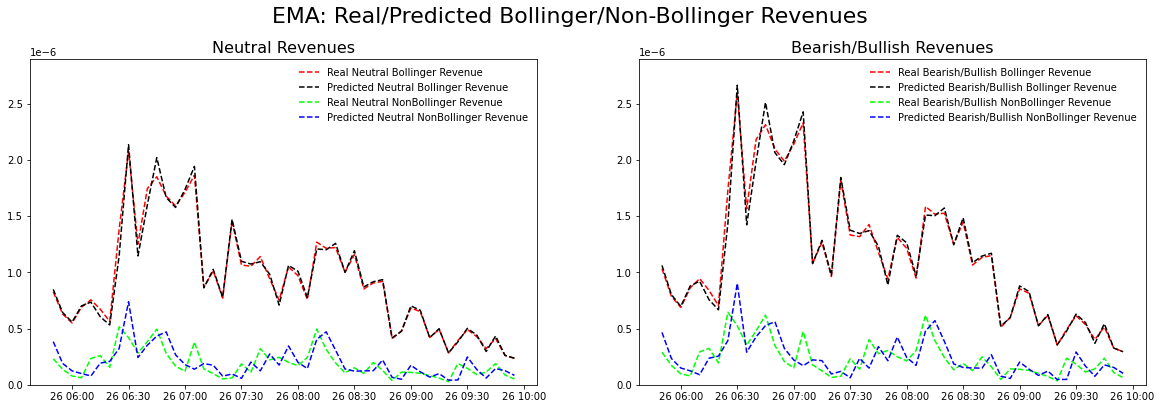

In [128]:
plt.figure(figsize=(20,6))

#Neutral
plt.subplot(1,2,1)
# Real Bollinger Neutral Revenue
plt.plot(0.003* (test_EMA_Bollinger_1['neutral_upper'] - test_EMA_Bollinger_1['neutral_lower']) *test_EMA_Bollinger_1['trades'], "r--", label="Real Neutral Bollinger Revenue", color='r')
# Predicted Bollinger Neutral Revenue
plt.plot(0.003* (test_EMA_Bollinger_1['predicted_neutral_upper'] - test_EMA_Bollinger_1['predicted_neutral_lower']) *test_EMA_Bollinger_1['trades'], "r--", label="Predicted Neutral Bollinger Revenue", color='black')
# Real Non-Bollinger Neutral Revenue
plt.plot(0.003* (test_EMA_Non_Bollinger_1['neutral_upper'] - test_EMA_Non_Bollinger_1['neutral_lower']) *test_EMA_Non_Bollinger_1['trades'], "r--", label="Real Neutral NonBollinger Revenue", color='lime')
# Predicted Non-Bollinger Neutral Revenue
plt.plot(0.003* (test_EMA_Non_Bollinger_1['predicted_neutral_upper'] - test_EMA_Non_Bollinger_1['predicted_neutral_lower']) *test_EMA_Non_Bollinger_1['trades'], "r--", label="Predicted Neutral NonBollinger Revenue", color='b')
plt.ylim(0, 2.9E-6)
plt.legend(loc= 'upper right', frameon=False)
plt.title('Neutral Revenues', fontsize=16)

plt.subplot(1,2,2)
#Bearish/Bullish
# Real Bollinger Bearish/Bullish Revenue
plt.plot(0.003* (test_EMA_Bollinger_1['bullish_upper'] - test_EMA_Bollinger_1['bullish_lower']) *test_EMA_Bollinger_1['trades'], "r--", label="Real Bearish/Bullish Bollinger Revenue", color='r')
# Predicted Bollinger Bearish/Bullish Revenue
plt.plot(0.003* (test_EMA_Bollinger_1['predicted_bullish_upper'] - test_EMA_Bollinger_1['predicted_bullish_lower']) *test_EMA_Bollinger_1['trades'], "r--", label="Predicted Bearish/Bullish Bollinger Revenue", color='black')
# Real Non-Bollinger Bearish/Bullish Revenue
plt.plot(0.003* (test_EMA_Non_Bollinger_1['bullish_upper'] - test_EMA_Non_Bollinger_1['bullish_lower']) *test_EMA_Non_Bollinger_1['trades'], "r--", label="Real Bearish/Bullish NonBollinger Revenue", color='lime')
# Predicted Non-Bollinger Bearish/Bullish Revenue
plt.plot(0.003* (test_EMA_Non_Bollinger_1['predicted_bullish_upper'] - test_EMA_Non_Bollinger_1['predicted_bullish_lower']) *test_EMA_Non_Bollinger_1['trades'], "r--", label="Predicted Bearish/Bullish NonBollinger Revenue", color='b')
plt.ylim(0, 2.9E-6)
plt.legend(loc= 'upper right', frameon=False)
plt.title('Bearish/Bullish Revenues', fontsize=16)

plt.suptitle('EMA: Real/Predicted Bollinger/Non-Bollinger Revenues',y=1,fontsize=22)


plt.show()

# Model_2

# EMA Bollinger Real & Predicted (span=20, no_of_std=2), Model_2

In [33]:
# Prediction of EMA Bollinger Bands (span=20, no_of_std=2)

def getEMABollingerBands (df):    
    # Calculate EMA & std
    EMA= df['close_price'].ewm(span=20).mean()
    std= df['close_price'].ewm(span=20).std()    
    # Calculate the upper and lower Bearish Bollinger Bands
    df['bearish_lower'] = (EMA - 1.5* 2 * std).abs()
    df['bearish_upper'] = EMA +  2 * std  
    # Calculate the upper and lower Neutral Bollinger Bands
    df['neutral_lower'] = (EMA - 2 * std).abs()
    df['neutral_upper'] = EMA + 2 * std
    # Calculate the upper and lower Bullish Bollinger Bands
    df['bullish_lower'] = (EMA - 2 * std).abs()
    df['bullish_upper'] = EMA + 1.5 * 2 * std
    
    df.dropna(inplace=True)
    
        
    df=df[['trades','close_price',
           'bearish_lower','bearish_upper', 
           'neutral_lower','neutral_upper',
           'bullish_lower','bullish_upper']]
    return df

copied_data=data.copy()
data_bands=getEMABollingerBands (copied_data)


def train_test_split(df, test_size):
    split = df.shape[0] - int(test_size * df.shape[0])
    train_set = df.iloc[:split]
    test_set = df.iloc[split:]
    return train_set, test_set

train_set, test_set = train_test_split(data_bands, 0.3)


def zero_scaling(df):   
    return df / df.iloc[0] - 1


def sliding_window(df, len_window, zero):   
    window = []
    for a in range(df.shape[0] - len_window):
        sub = df[a: (a + len_window)].copy()
        if zero:
            sub = zero_scaling(sub)
        window.append(sub.values)
    return np.array(window)


def prepare_data(column, len_window, zero):     
    train_data = train_set[[column]]
    test_data = test_set[[column]]  
    
    X_train = sliding_window(train_data, len_window, zero)  
    X_test = sliding_window(test_data, len_window, zero) 
    
    y_train = train_data[column][len_window:].values
    y_test = test_data[column][len_window:].values
    
    if zero:
        y_train = y_train / train_data[column][:-len_window].values - 1
        y_test = y_test / test_data[column][:-len_window].values - 1
        
    return train_data,  test_data, X_train, X_test,  y_train, y_test



data_final_EMA_Bollinger_2= test_set.copy()

for col in test_set.columns[1:]:
    train_data,  test_data, X_train, X_test,  y_train, y_test = prepare_data(column=col, len_window=5, zero=True)
    
    model_2 = Sequential()
    model_2.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    model_2.add(Dropout(0.2))
    model_2.add(LSTM(units = 50, return_sequences = True))
    model_2.add(Dropout(0.2))
    model_2.add(LSTM(units = 50, return_sequences = True))
    model_2.add(Dropout(0.2))
    model_2.add(LSTM(units = 50))
    model_2.add(Dropout(0.2))
    model_2.add(Dense(units = 1))
    model_2.compile(optimizer = 'adam', loss = 'mean_squared_error')
    model_2.fit(X_train, y_train, validation_split=0.1, epochs = 30, batch_size = 32, verbose=1, shuffle=False)
    
    prediction=model_2.predict(X_test).squeeze()
    
    predicted= pd.DataFrame(data=(prediction + 1) * (test_data[col][:-5].values) ,  index=test_data[5:].index ,columns=['predicted_'+col] )            

    data_final_EMA_Bollinger_2= data_final_EMA_Bollinger_2.join(predicted)

data_final_EMA_Bollinger_2;

Epoch 1/30
203/203 [==============================] - 10s 20ms/step - loss: 1.1544e-04 - val_loss: 1.4183e-04
Epoch 2/30
203/203 [==============================] - 3s 14ms/step - loss: 1.0598e-04 - val_loss: 1.3459e-04
Epoch 3/30
203/203 [==============================] - 3s 13ms/step - loss: 1.0474e-04 - val_loss: 1.3332e-04
Epoch 4/30
203/203 [==============================] - 2s 12ms/step - loss: 1.0316e-04 - val_loss: 1.2967e-04
Epoch 5/30
203/203 [==============================] - 3s 12ms/step - loss: 8.6959e-05 - val_loss: 5.4272e-05
Epoch 6/30
203/203 [==============================] - 3s 12ms/step - loss: 4.2119e-05 - val_loss: 3.5816e-05
Epoch 7/30
203/203 [==============================] - 3s 14ms/step - loss: 3.4985e-05 - val_loss: 3.2956e-05
Epoch 8/30
203/203 [==============================] - 3s 14ms/step - loss: 3.2561e-05 - val_loss: 3.2203e-05
Epoch 9/30
203/203 [==============================] - 3s 15ms/step - loss: 3.2314e-05 - val_loss: 3.2887e-05
Epoch 10/30
203/20

203/203 [==============================] - 2s 12ms/step - loss: 4.2138e-05 - val_loss: 4.8640e-05
Epoch 16/30
203/203 [==============================] - 2s 11ms/step - loss: 4.2143e-05 - val_loss: 4.8710e-05
Epoch 17/30
203/203 [==============================] - 2s 12ms/step - loss: 4.1971e-05 - val_loss: 4.8595e-05
Epoch 18/30
203/203 [==============================] - 2s 11ms/step - loss: 4.1749e-05 - val_loss: 4.8140e-05
Epoch 19/30
203/203 [==============================] - 2s 12ms/step - loss: 4.1781e-05 - val_loss: 4.8449e-05
Epoch 20/30
203/203 [==============================] - 2s 12ms/step - loss: 4.1644e-05 - val_loss: 4.8403e-05
Epoch 21/30
203/203 [==============================] - 2s 11ms/step - loss: 4.1556e-05 - val_loss: 4.8054e-05
Epoch 22/30
203/203 [==============================] - 2s 11ms/step - loss: 4.1831e-05 - val_loss: 4.8045e-05
Epoch 23/30
203/203 [==============================] - 2s 11ms/step - loss: 4.1692e-05 - val_loss: 4.8315e-05
Epoch 24/30
203/203 [=

Epoch 30/30
203/203 [==============================] - 3s 12ms/step - loss: 3.9493e-06 - val_loss: 3.4868e-06
Epoch 1/30
203/203 [==============================] - 9s 17ms/step - loss: 4.7236e-05 - val_loss: 5.8429e-05
Epoch 2/30
203/203 [==============================] - 2s 11ms/step - loss: 3.8888e-05 - val_loss: 4.3319e-05
Epoch 3/30
203/203 [==============================] - 2s 11ms/step - loss: 3.7865e-05 - val_loss: 3.8808e-05
Epoch 4/30
203/203 [==============================] - 2s 12ms/step - loss: 3.6995e-05 - val_loss: 3.6150e-05
Epoch 5/30
203/203 [==============================] - 3s 15ms/step - loss: 3.6461e-05 - val_loss: 3.4386e-05
Epoch 6/30
203/203 [==============================] - 3s 13ms/step - loss: 3.6120e-05 - val_loss: 3.1362e-05
Epoch 7/30
203/203 [==============================] - 3s 13ms/step - loss: 3.5451e-05 - val_loss: 3.0407e-05
Epoch 8/30
203/203 [==============================] - 3s 13ms/step - loss: 3.5116e-05 - val_loss: 2.9812e-05
Epoch 9/30
203/203

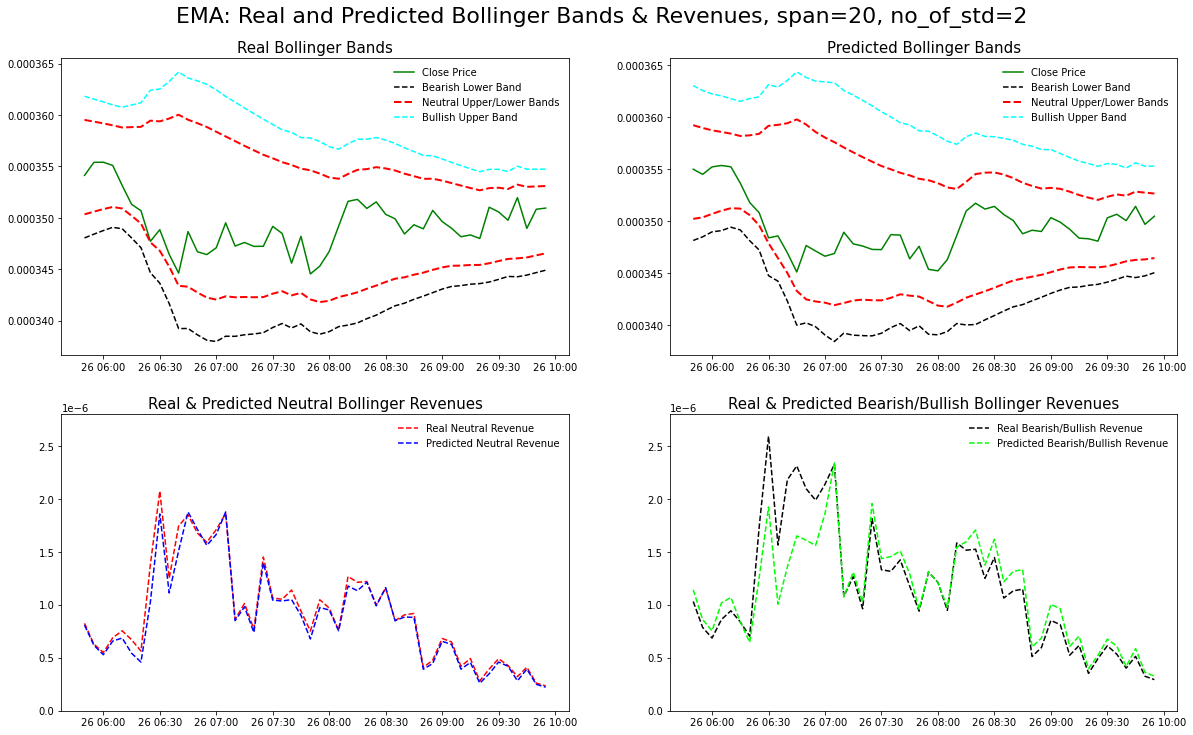

In [253]:
#EMA, Bollinger
test_EMA_Bollinger_2=data_final_EMA_Bollinger_2[-150:-100]

plt.figure(figsize=(20,12))
#Real Bands
plt.subplot(2,2,1)
plt.plot(test_EMA_Bollinger_2['close_price'], label="Close Price", color='g')
plt.plot(test_EMA_Bollinger_2['bearish_lower'], "r--", label="Bearish Lower Band", color='black')
plt.plot(test_EMA_Bollinger_2['neutral_lower'], "r--", color='r', lw=2)
plt.plot(test_EMA_Bollinger_2['neutral_upper'], "r--", label="Neutral Upper/Lower Bands", color='r',lw=2)
plt.plot(test_EMA_Bollinger_2['bullish_upper'], "r--", label="Bullish Upper Band", color='cyan')
plt.legend(loc= 'upper right', frameon=False)
plt.title('Real Bollinger Bands', fontsize=15)
#Predicted Bands
plt.subplot(2,2,2)
plt.plot(test_EMA_Bollinger_2['predicted_close_price'], label="Close Price", color='g' )
plt.plot(test_EMA_Bollinger_2['predicted_bearish_lower'], "r--", label="Bearish Lower Band", color='black')
plt.plot(test_EMA_Bollinger_2['predicted_neutral_lower'], "r--", color='r', lw=2)
plt.plot(test_EMA_Bollinger_2['predicted_neutral_upper'], "r--", label="Neutral Upper/Lower Bands", color='r', lw=2)
plt.plot(test_EMA_Bollinger_2['predicted_bullish_upper'], "r--", label="Bullish Upper Band", color='cyan')
plt.legend(loc= 'upper right', frameon=False)
plt.title('Predicted Bollinger Bands', fontsize=15)

#Compare Real & Predicted Neutral Revenues
plt.subplot(2,2,3)
plt.plot(0.003* (test_EMA_Bollinger_2['neutral_upper'] - test_EMA_Bollinger_2['neutral_lower']) *test_EMA_Bollinger_2['trades'], "r--", label="Real Neutral Revenue", color='r')
plt.plot(0.003* (test_EMA_Bollinger_2['predicted_neutral_upper'] - test_EMA_Bollinger_2['predicted_neutral_lower']) *test_EMA_Bollinger_2['trades'], "r--", label="Predicted Neutral Revenue", color='b')
plt.legend(loc= 'upper right', frameon=False)
plt.ylim(0, 2.8E-6)
plt.title('Real & Predicted Neutral Bollinger Revenues', fontsize=15)

#Compare Real & Predicted Bearish/Bullish Revenue Revenues
plt.subplot(2,2,4)
plt.plot(0.003* (test_EMA_Bollinger_2['bullish_upper'] - test_EMA_Bollinger_2['bullish_lower']) *test_EMA_Bollinger_2['trades'], "r--", label="Real Bearish/Bullish Revenue", color='black')
plt.plot(0.003* (test_EMA_Bollinger_2['predicted_bullish_upper'] - test_EMA_Bollinger_2['predicted_bullish_lower']) *test_EMA_Bollinger_2['trades'], "r--", label="Predicted Bearish/Bullish Revenue", color='lime')
plt.legend(loc= 'upper right', frameon=False)
plt.ylim(0, 2.8E-6)
plt.title('Real & Predicted Bearish/Bullish Bollinger Revenues', fontsize=15)

plt.suptitle('EMA: Real and Predicted Bollinger Bands & Revenues, span=20, no_of_std=2',y=0.94,fontsize=22)
plt.show()

# EMA Non-Bollinger Real & Predicted (span=2, no_of_std=0.9), Model_2

In [36]:
def getEMABollingerBands (df):    
    # Calculate EMA & std
    EMA= df['close_price'].ewm(span=2).mean()
    std= df['close_price'].ewm(span=2).std()    
    # Calculate the upper and lower Bearish Bollinger Bands
    df['bearish_lower'] = (EMA - 1.5* 0.9 * std).abs()
    df['bearish_upper'] = EMA +  0.9 * std  
    # Calculate the upper and lower Neutral Bollinger Bands
    df['neutral_lower'] = (EMA - 0.9 * std).abs()
    df['neutral_upper'] = EMA + 0.9 * std
    # Calculate the upper and lower Bullish Bollinger Bands
    df['bullish_lower'] = (EMA - 0.9 * std).abs()
    df['bullish_upper'] = EMA + 1.5 * 0.9 * std
    
    df.dropna(inplace=True)
    
    
    df=df[['trades','close_price',
           'bearish_lower','bearish_upper', 
           'neutral_lower','neutral_upper',
           'bullish_lower','bullish_upper']]
    
    return df

copied_data=data.copy()
data_bands=getEMABollingerBands (copied_data)


def train_test_split(df, test_size):
    split = df.shape[0] - int(test_size * df.shape[0])
    train_set = df.iloc[:split]
    test_set = df.iloc[split:]
    return train_set, test_set

train_set, test_set = train_test_split(data_bands, 0.3)


def zero_scaling(df):   
    return df / df.iloc[0] - 1


def sliding_window(df, len_window, zero):   
    window = []
    for a in range(df.shape[0] - len_window):
        sub = df[a: (a + len_window)].copy()
        if zero:
            sub = zero_scaling(sub)
        window.append(sub.values)
    return np.array(window)


def prepare_data(column, len_window, zero):     
    train_data = train_set[[column]]
    test_data = test_set[[column]]  
    
    X_train = sliding_window(train_data, len_window, zero)  
    X_test = sliding_window(test_data, len_window, zero) 
    
    y_train = train_data[column][len_window:].values
    y_test = test_data[column][len_window:].values
    
    if zero:
        y_train = y_train / train_data[column][:-len_window].values - 1
        y_test = y_test / test_data[column][:-len_window].values - 1
        
    return train_data,  test_data, X_train, X_test,  y_train, y_test



data_final_EMA_Non_Bollinger_2= test_set.copy()

for col in test_set.columns[1:]:
    train_data,  test_data, X_train, X_test,  y_train, y_test = prepare_data(column=col, len_window=5, zero=True)
    
    model_2 = Sequential()
    model_2.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    model_2.add(Dropout(0.2))
    model_2.add(LSTM(units = 50, return_sequences = True))
    model_2.add(Dropout(0.2))
    model_2.add(LSTM(units = 50, return_sequences = True))
    model_2.add(Dropout(0.2))
    model_2.add(LSTM(units = 50))
    model_2.add(Dropout(0.2))
    model_2.add(Dense(units = 1))
    model_2.compile(optimizer = 'adam', loss = 'mean_squared_error')
    
    model_2.fit(X_train, y_train, validation_split=0.1, epochs = 30, batch_size = 32, verbose=1, shuffle=False)
    
    prediction=model_2.predict(X_test).squeeze()
        
    predicted= pd.DataFrame(data=(prediction + 1) * (test_data[col][:-5].values) ,  index=test_data[5:].index ,columns=['predicted_'+col] )            

    data_final_EMA_Non_Bollinger_2= data_final_EMA_Non_Bollinger_2.join(predicted)

data_final_EMA_Non_Bollinger_2;

Epoch 1/30
203/203 [==============================] - 10s 20ms/step - loss: 1.1427e-04 - val_loss: 1.4179e-04
Epoch 2/30
203/203 [==============================] - 3s 16ms/step - loss: 1.0540e-04 - val_loss: 1.3271e-04
Epoch 3/30
203/203 [==============================] - 3s 13ms/step - loss: 1.0385e-04 - val_loss: 1.2951e-04
Epoch 4/30
203/203 [==============================] - 3s 13ms/step - loss: 9.3275e-05 - val_loss: 5.7381e-05
Epoch 5/30
203/203 [==============================] - 3s 13ms/step - loss: 4.9313e-05 - val_loss: 3.7960e-05
Epoch 6/30
203/203 [==============================] - 3s 15ms/step - loss: 3.5395e-05 - val_loss: 3.4681e-05
Epoch 7/30
203/203 [==============================] - 3s 13ms/step - loss: 3.3514e-05 - val_loss: 3.4680e-05
Epoch 8/30
203/203 [==============================] - 3s 14ms/step - loss: 3.4176e-05 - val_loss: 3.2511e-05
Epoch 9/30
203/203 [==============================] - 3s 13ms/step - loss: 3.1828e-05 - val_loss: 3.1837e-05
Epoch 10/30
203/20

203/203 [==============================] - 3s 12ms/step - loss: 2.1415e-05 - val_loss: 1.9384e-05
Epoch 16/30
203/203 [==============================] - 3s 13ms/step - loss: 1.9886e-05 - val_loss: 1.9200e-05
Epoch 17/30
203/203 [==============================] - 3s 13ms/step - loss: 2.0442e-05 - val_loss: 1.9952e-05
Epoch 18/30
203/203 [==============================] - 3s 13ms/step - loss: 2.0400e-05 - val_loss: 1.9208e-05
Epoch 19/30
203/203 [==============================] - 3s 15ms/step - loss: 1.9821e-05 - val_loss: 2.0683e-05
Epoch 20/30
203/203 [==============================] - 3s 15ms/step - loss: 2.0829e-05 - val_loss: 1.9319e-05
Epoch 21/30
203/203 [==============================] - 3s 14ms/step - loss: 1.9543e-05 - val_loss: 1.9117e-05
Epoch 22/30
203/203 [==============================] - 2s 12ms/step - loss: 2.0489e-05 - val_loss: 1.9639e-05
Epoch 23/30
203/203 [==============================] - 2s 12ms/step - loss: 2.0094e-05 - val_loss: 1.8930e-05
Epoch 24/30
203/203 [=

Epoch 30/30
203/203 [==============================] - 3s 12ms/step - loss: 1.9596e-05 - val_loss: 1.9441e-05
Epoch 1/30
203/203 [==============================] - 10s 21ms/step - loss: 9.7841e-05 - val_loss: 1.1567e-04
Epoch 2/30
203/203 [==============================] - 3s 14ms/step - loss: 8.4981e-05 - val_loss: 1.1203e-04
Epoch 3/30
203/203 [==============================] - 3s 14ms/step - loss: 8.4911e-05 - val_loss: 1.0904e-04
Epoch 4/30
203/203 [==============================] - 3s 14ms/step - loss: 8.4055e-05 - val_loss: 1.0897e-04
Epoch 5/30
203/203 [==============================] - 3s 13ms/step - loss: 8.1961e-05 - val_loss: 9.5818e-05
Epoch 6/30
203/203 [==============================] - 3s 13ms/step - loss: 6.3368e-05 - val_loss: 3.1889e-05
Epoch 7/30
203/203 [==============================] - 3s 13ms/step - loss: 2.6614e-05 - val_loss: 2.0897e-05
Epoch 8/30
203/203 [==============================] - 3s 14ms/step - loss: 2.1114e-05 - val_loss: 1.9867e-05
Epoch 9/30
203/20

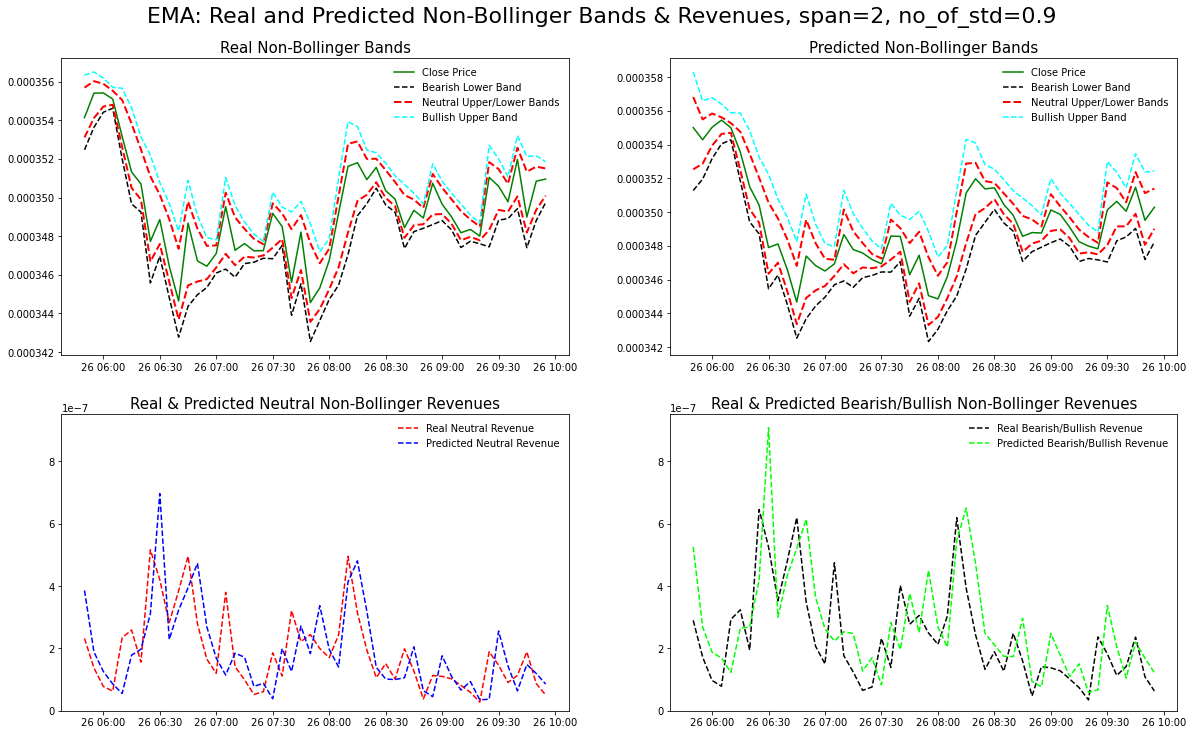

In [149]:
#EMA, NonBollinger
test_EMA_Non_Bollinger_2=data_final_EMA_Non_Bollinger_2[-150:-100]

plt.figure(figsize=(20,12))
#Real Bands
plt.subplot(2,2,1)
plt.plot(test_EMA_Non_Bollinger_2['close_price'], label="Close Price", color='g')
plt.plot(test_EMA_Non_Bollinger_2['bearish_lower'], "r--", label="Bearish Lower Band", color='black')
plt.plot(test_EMA_Non_Bollinger_2['neutral_lower'], "r--", color='r', lw=2)
plt.plot(test_EMA_Non_Bollinger_2['neutral_upper'], "r--", label="Neutral Upper/Lower Bands", color='r',lw=2)
plt.plot(test_EMA_Non_Bollinger_2['bullish_upper'], "r--", label="Bullish Upper Band", color='cyan')
plt.legend(loc= 'upper right', frameon=False)
plt.title('Real Non-Bollinger Bands', fontsize=15)
#Predicted Bands
plt.subplot(2,2,2)
plt.plot(test_EMA_Non_Bollinger_2['predicted_close_price'], label="Close Price", color='g' )
plt.plot(test_EMA_Non_Bollinger_2['predicted_bearish_lower'], "r--", label="Bearish Lower Band", color='black')
plt.plot(test_EMA_Non_Bollinger_2['predicted_neutral_lower'], "r--", color='r', lw=2)
plt.plot(test_EMA_Non_Bollinger_2['predicted_neutral_upper'], "r--", label="Neutral Upper/Lower Bands", color='r', lw=2)
plt.plot(test_EMA_Non_Bollinger_2['predicted_bullish_upper'], "r--", label="Bullish Upper Band", color='cyan')
plt.legend(loc= 'upper right', frameon=False)
plt.title('Predicted Non-Bollinger Bands', fontsize=15)

#Compare Real & Predicted Neutral Revenues
plt.subplot(2,2,3)
plt.plot(0.003* (test_EMA_Non_Bollinger_2['neutral_upper'] - test_EMA_Non_Bollinger_2['neutral_lower']) *test_EMA_Non_Bollinger_2['trades'], "r--", label="Real Neutral Revenue", color='r')
plt.plot(0.003* (test_EMA_Non_Bollinger_2['predicted_neutral_upper'] - test_EMA_Non_Bollinger_2['predicted_neutral_lower']) *test_EMA_Non_Bollinger_2['trades'], "r--", label="Predicted Neutral Revenue", color='b')
plt.legend(loc= 'upper right', frameon=False)
plt.ylim(0, 9.5E-7)

plt.title('Real & Predicted Neutral Non-Bollinger Revenues', fontsize=15)

#Compare Real & Predicted Bearish/Bullish Revenue Revenues
plt.subplot(2,2,4)
plt.plot(0.003* (test_EMA_Non_Bollinger_2['bullish_upper'] - test_EMA_Non_Bollinger_2['bullish_lower']) *test_EMA_Non_Bollinger_2['trades'], "r--", label="Real Bearish/Bullish Revenue", color='black')
plt.plot(0.003* (test_EMA_Non_Bollinger_2['predicted_bullish_upper'] - test_EMA_Non_Bollinger_2['predicted_bullish_lower']) *test_EMA_Non_Bollinger_2['trades'], "r--", label="Predicted Bearish/Bullish Revenue", color='lime')
plt.legend(loc= 'upper right', frameon=False)
plt.ylim(0, 9.5E-7)
plt.title('Real & Predicted Bearish/Bullish Non-Bollinger Revenues', fontsize=15)

plt.suptitle('EMA: Real and Predicted Non-Bollinger Bands & Revenues, span=2, no_of_std=0.9',y=0.94,fontsize=22)
plt.show()

# Comparing Real/Predicted Bollinger/Non-Bollinger Revenues, Model_2

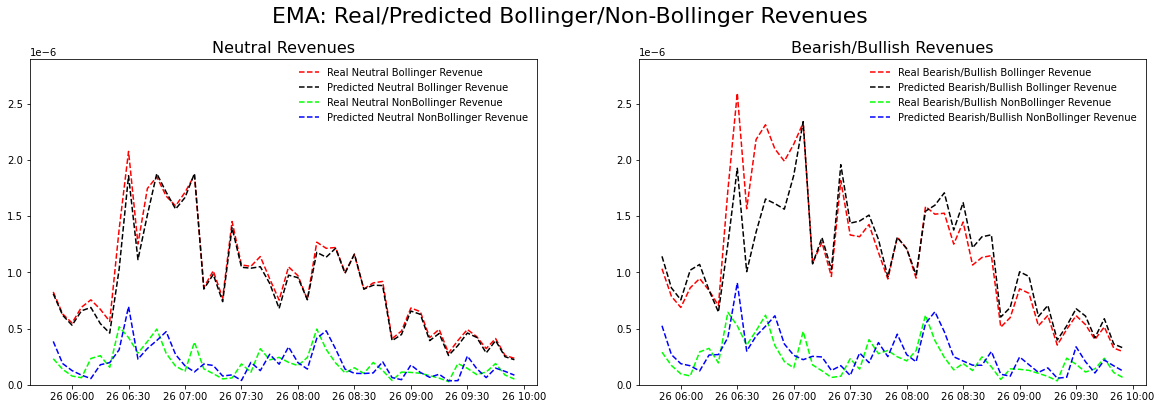

In [157]:
plt.figure(figsize=(20,6))

#Neutral

plt.subplot(1,2,1)
# Real Bollinger Neutral Revenue
plt.plot(0.003* (test_EMA_Bollinger_2['neutral_upper'] - test_EMA_Bollinger_2['neutral_lower']) *test_EMA_Bollinger_2['trades'], "r--", label="Real Neutral Bollinger Revenue", color='r')
# Predicted Bollinger Neutral Revenue
plt.plot(0.003* (test_EMA_Bollinger_2['predicted_neutral_upper'] - test_EMA_Bollinger_2['predicted_neutral_lower']) *test_EMA_Bollinger_2['trades'], "r--", label="Predicted Neutral Bollinger Revenue", color='black')
# Real Non-Bollinger Neutral Revenue
plt.plot(0.003* (test_EMA_Non_Bollinger_2['neutral_upper'] - test_EMA_Non_Bollinger_2['neutral_lower']) *test_EMA_Non_Bollinger_2['trades'], "r--", label="Real Neutral NonBollinger Revenue", color='lime')
# Predicted Non-Bollinger Neutral Revenue
plt.plot(0.003* (test_EMA_Non_Bollinger_2['predicted_neutral_upper'] - test_EMA_Non_Bollinger_2['predicted_neutral_lower']) *test_EMA_Non_Bollinger_2['trades'], "r--", label="Predicted Neutral NonBollinger Revenue", color='b')
plt.ylim(0, 2.9E-6)
plt.legend(loc= 'upper right', frameon=False)
plt.title('Neutral Revenues', fontsize=16)

#Bearish/Bullish

plt.subplot(1,2,2)
# Real Bollinger Bearish/Bullish Revenue
plt.plot(0.003* (test_EMA_Bollinger_2['bullish_upper'] - test_EMA_Bollinger_2['bullish_lower']) *test_EMA_Bollinger_2['trades'], "r--", label="Real Bearish/Bullish Bollinger Revenue", color='r')
# Predicted Bollinger Bearish/Bullish Revenue
plt.plot(0.003* (test_EMA_Bollinger_2['predicted_bullish_upper'] - test_EMA_Bollinger_2['predicted_bullish_lower']) *test_EMA_Bollinger_2['trades'], "r--", label="Predicted Bearish/Bullish Bollinger Revenue", color='black')
# Real Non-Bollinger Bearish/Bullish Revenue
plt.plot(0.003* (test_EMA_Non_Bollinger_2['bullish_upper'] - test_EMA_Non_Bollinger_2['bullish_lower']) *test_EMA_Non_Bollinger_2['trades'], "r--", label="Real Bearish/Bullish NonBollinger Revenue", color='lime')
# Predicted Non-Bollinger Bearish/Bullish Revenue
plt.plot(0.003* (test_EMA_Non_Bollinger_2['predicted_bullish_upper'] - test_EMA_Non_Bollinger_2['predicted_bullish_lower']) *test_EMA_Non_Bollinger_2['trades'], "r--", label="Predicted Bearish/Bullish NonBollinger Revenue", color='b')
plt.ylim(0, 2.9E-6)
plt.legend(loc= 'upper right', frameon=False)
plt.title('Bearish/Bullish Revenues', fontsize=16)

plt.suptitle('EMA: Real/Predicted Bollinger/Non-Bollinger Revenues',y=1,fontsize=22)


plt.show()

# Comparing Model_1 and Model_2

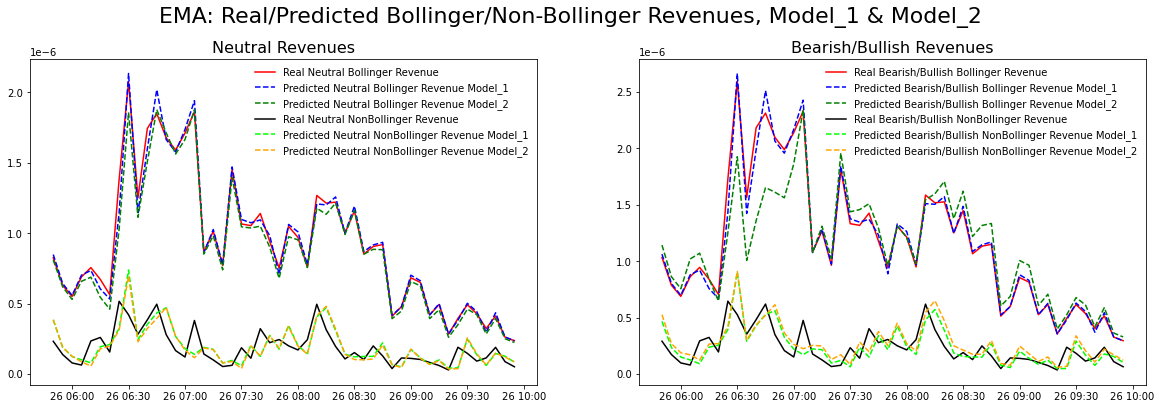

In [240]:
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
# Real Neutral Bollinger Revenues model_1 and model_2
plt.plot(0.003* (test_EMA_Bollinger_1['neutral_upper'] - test_EMA_Bollinger_1['neutral_lower']) *test_EMA_Bollinger_1['trades'], label="Real Neutral Bollinger Revenue", color='r')
# Predicted Neutral Bollinger Revenues model 1
plt.plot(0.003* (test_EMA_Bollinger_1['predicted_neutral_upper'] - test_EMA_Bollinger_1['predicted_neutral_lower']) *test_EMA_Bollinger_1['trades'], "r--", label="Predicted Neutral Bollinger Revenue Model_1", color='b')
# Predicted Neutral Bollinger Revenues model 2
plt.plot(0.003* (test_EMA_Bollinger_2['predicted_neutral_upper'] - test_EMA_Bollinger_2['predicted_neutral_lower']) *test_EMA_Bollinger_2['trades'], "r--", label="Predicted Neutral Bollinger Revenue Model_2", color='g')
# Real Neutral NonBollinger Revenues model_1 and model_2
plt.plot(0.003* (test_EMA_Non_Bollinger_1['neutral_upper'] - test_EMA_Non_Bollinger_1['neutral_lower']) *test_EMA_Non_Bollinger_1['trades'],  label="Real Neutral NonBollinger Revenue", color='black')
# Predicted Neutral NonBollinger Revenues model 1
plt.plot(0.003* (test_EMA_Non_Bollinger_1['predicted_neutral_upper'] - test_EMA_Non_Bollinger_1['predicted_neutral_lower']) *test_EMA_Non_Bollinger_1['trades'], "r--", label="Predicted Neutral NonBollinger Revenue Model_1", color='lime')
# Predicted Neutral NonBollinger Revenues model 2
plt.plot(0.003* (test_EMA_Non_Bollinger_2['predicted_neutral_upper'] - test_EMA_Non_Bollinger_2['predicted_neutral_lower']) *test_EMA_Non_Bollinger_2['trades'], "r--", label="Predicted Neutral NonBollinger Revenue Model_2", color='orange')
plt.legend(frameon=False)
plt.title('Neutral Revenues', fontsize=16)

plt.subplot(1,2,2)
# Real Bearish/Bullish Bollinger Revenues model_1 and model_2
plt.plot(0.003* (test_EMA_Bollinger_1['bullish_upper'] - test_EMA_Bollinger_1['bullish_lower']) *test_EMA_Bollinger_1['trades'], label="Real Bearish/Bullish Bollinger Revenue", color='r')
# Predicted Bearish/Bullish Bollinger Revenues model 1
plt.plot(0.003* (test_EMA_Bollinger_1['predicted_bullish_upper'] - test_EMA_Bollinger_1['predicted_bullish_lower']) *test_EMA_Bollinger_1['trades'], "r--", label="Predicted Bearish/Bullish Bollinger Revenue Model_1", color='b')
# Predicted Bearish/Bullish Bollinger Revenues model 2
plt.plot(0.003* (test_EMA_Bollinger_2['predicted_bullish_upper'] - test_EMA_Bollinger_2['predicted_bullish_lower']) *test_EMA_Bollinger_2['trades'], "r--", label="Predicted Bearish/Bullish Bollinger Revenue Model_2", color='g')
# Real Bearish/Bullish NonBollinger Revenues model_1 and model_2
plt.plot(0.003* (test_EMA_Non_Bollinger_1['bullish_upper'] - test_EMA_Non_Bollinger_1['bullish_lower']) *test_EMA_Non_Bollinger_1['trades'],  label="Real Bearish/Bullish NonBollinger Revenue", color='black')
# Predicted Bearish/Bullish NonBollinger Revenues model 1
plt.plot(0.003* (test_EMA_Non_Bollinger_1['predicted_bullish_upper'] - test_EMA_Non_Bollinger_1['predicted_bullish_lower']) *test_EMA_Non_Bollinger_1['trades'], "r--", label="Predicted Bearish/Bullish NonBollinger Revenue Model_1", color='lime')
# Predicted Bearish/Bullish NonBollinger Revenues model 2
plt.plot(0.003* (test_EMA_Non_Bollinger_2['predicted_bullish_upper'] - test_EMA_Non_Bollinger_2['predicted_bullish_lower']) *test_EMA_Non_Bollinger_2['trades'], "r--", label="Predicted Bearish/Bullish NonBollinger Revenue Model_2", color='orange')
plt.legend(frameon=False)
plt.title('Bearish/Bullish Revenues', fontsize=16)

plt.suptitle('EMA: Real/Predicted Bollinger/Non-Bollinger Revenues, Model_1 & Model_2',y=1,fontsize=22)

plt.show()

In [228]:
# Neutral Bollinger & NonBollinger Revenues Errors by model_1  & model_2

print('Neutral Bollinger Revenues model_1 Error= ',
      mean_absolute_error(0.003* (test_EMA_Bollinger_1['neutral_upper'] - test_EMA_Bollinger_1['neutral_lower']) *test_EMA_Bollinger_1['trades'],
                   0.003* (test_EMA_Bollinger_1['predicted_neutral_upper'] - test_EMA_Bollinger_1['predicted_neutral_lower'])))

print('Neutral Bollinger Revenues model_2 Error= ',
      mean_absolute_error(0.003* (test_EMA_Bollinger_1['neutral_upper'] - test_EMA_Bollinger_1['neutral_lower']) *test_EMA_Bollinger_1['trades'],
                   0.003* (test_EMA_Bollinger_2['predicted_neutral_upper'] - test_EMA_Bollinger_2['predicted_neutral_lower'])))

print('Neutral NonBollinger Revenues model_1 Error= ',
mean_absolute_error(0.003* (test_EMA_Non_Bollinger_1['neutral_upper'] - test_EMA_Non_Bollinger_1['neutral_lower']) *test_EMA_Non_Bollinger_1['trades'],
                    0.003* (test_EMA_Non_Bollinger_1['predicted_neutral_upper'] - test_EMA_Non_Bollinger_1['predicted_neutral_lower']) *test_EMA_Non_Bollinger_1['trades']))
print('Neutral NonBollinger Revenues model_2 Error= ',
mean_absolute_error(0.003* (test_EMA_Non_Bollinger_1['neutral_upper'] - test_EMA_Non_Bollinger_1['neutral_lower']) *test_EMA_Non_Bollinger_1['trades'],
                    0.003* (test_EMA_Non_Bollinger_2['predicted_neutral_upper'] - test_EMA_Non_Bollinger_2['predicted_neutral_lower']) *test_EMA_Non_Bollinger_2['trades']))

print('\n')


# Bearish/Bullish Bollinger Bollinger & NonBollinger Revenues Errors by model_1  & model_2

print('Bearish/Bullish Bollinger Revenues model_1 Error= ',
      mean_absolute_error(0.003* (test_EMA_Bollinger_1['bullish_upper'] - test_EMA_Bollinger_1['bullish_lower']) *test_EMA_Bollinger_1['trades'],
                   0.003* (test_EMA_Bollinger_1['predicted_bullish_upper'] - test_EMA_Bollinger_1['predicted_bullish_lower'])))

print('Bearish/Bullish Bollinger Revenues model_2 Error= ',
      mean_absolute_error(0.003* (test_EMA_Bollinger_1['bullish_upper'] - test_EMA_Bollinger_1['neutral_lower']) *test_EMA_Bollinger_1['trades'],
                   0.003* (test_EMA_Bollinger_2['predicted_bullish_upper'] - test_EMA_Bollinger_2['predicted_bullish_lower'])))

print('Bearish/Bullish NonBollinger Revenues model_1 Error= ',
mean_absolute_error(0.003* (test_EMA_Non_Bollinger_1['bullish_upper'] - test_EMA_Non_Bollinger_1['bullish_lower']) *test_EMA_Non_Bollinger_1['trades'],
                    0.003* (test_EMA_Non_Bollinger_1['predicted_bullish_upper'] - test_EMA_Non_Bollinger_1['predicted_bullish_lower']) *test_EMA_Non_Bollinger_1['trades']))
print('Bearish/Bullish NonBollinger Revenues model_2 Error= ',
mean_absolute_error(0.003* (test_EMA_Non_Bollinger_1['bullish_upper'] - test_EMA_Non_Bollinger_1['bullish_lower']) *test_EMA_Non_Bollinger_1['trades'],
                    0.003* (test_EMA_Non_Bollinger_2['predicted_bullish_upper'] - test_EMA_Non_Bollinger_2['predicted_bullish_lower']) *test_EMA_Non_Bollinger_2['trades']))

Neutral Bollinger Revenues model_1 Error=  8.905301069539504e-07
Neutral Bollinger Revenues model_2 Error=  8.921791374459672e-07
Neutral NonBollinger Revenues model_1 Error=  8.198459895638531e-08
Neutral NonBollinger Revenues model_2 Error=  8.36981681438686e-08


Bearish/Bullish Bollinger Revenues model_1 Error=  1.1131852194779253e-06
Bearish/Bullish Bollinger Revenues model_2 Error=  1.1129173795082151e-06
Bearish/Bullish NonBollinger Revenues model_1 Error=  1.0110573550808693e-07
Bearish/Bullish NonBollinger Revenues model_2 Error=  1.1381856958571191e-07


The mean_absolute_error obtained from model_2 is higher than model_1, so we select model_1.

# Best Results

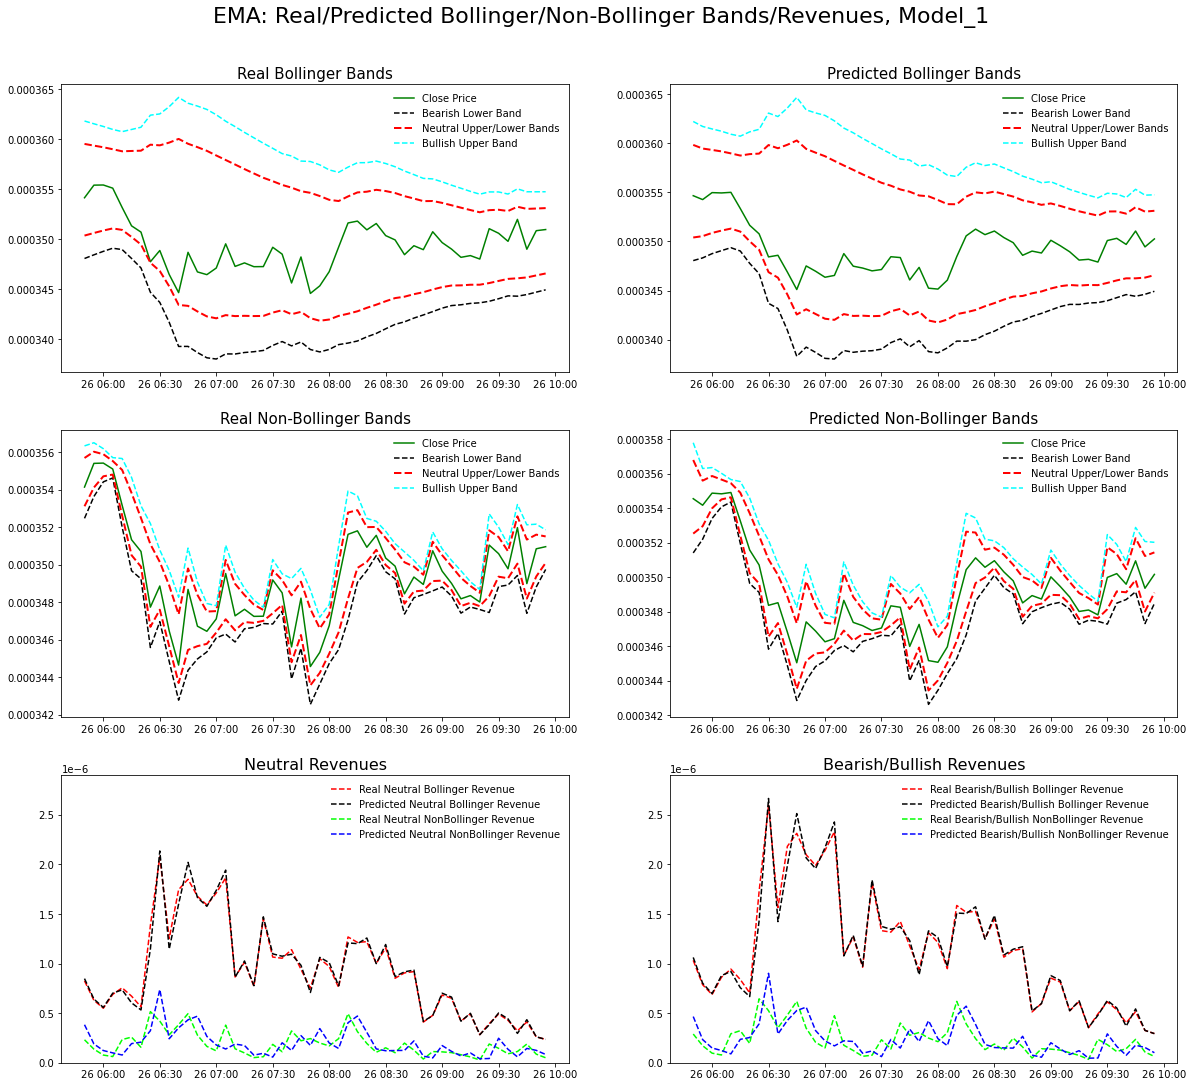

In [254]:
plt.figure(figsize=(20,18))


#Real Bollinger Bands
plt.subplot(3,2,1)
plt.plot(test_EMA_Bollinger_1['close_price'], label="Close Price", color='g')
plt.plot(test_EMA_Bollinger_1['bearish_lower'], "r--", label="Bearish Lower Band", color='black')
plt.plot(test_EMA_Bollinger_1['neutral_lower'], "r--", color='r', lw=2)
plt.plot(test_EMA_Bollinger_1['neutral_upper'], "r--", label="Neutral Upper/Lower Bands", color='r',lw=2)
plt.plot(test_EMA_Bollinger_1['bullish_upper'], "r--", label="Bullish Upper Band", color='cyan')
plt.legend(loc= 'upper right', frameon=False)
plt.title('Real Bollinger Bands', fontsize=15)
#Predicted Bollinger Bands
plt.subplot(3,2,2)
plt.plot(test_EMA_Bollinger_1['predicted_close_price'], label="Close Price", color='g' )
plt.plot(test_EMA_Bollinger_1['predicted_bearish_lower'], "r--", label="Bearish Lower Band", color='black')
plt.plot(test_EMA_Bollinger_1['predicted_neutral_lower'], "r--", color='r', lw=2)
plt.plot(test_EMA_Bollinger_1['predicted_neutral_upper'], "r--", label="Neutral Upper/Lower Bands", color='r', lw=2)
plt.plot(test_EMA_Bollinger_1['predicted_bullish_upper'], "r--", label="Bullish Upper Band", color='cyan')
plt.legend(loc= 'upper right', frameon=False)
plt.title('Predicted Bollinger Bands', fontsize=15)


#Real NonBollinger Bands
plt.subplot(3,2,3)
plt.plot(test_EMA_Non_Bollinger_1['close_price'], label="Close Price", color='g')
plt.plot(test_EMA_Non_Bollinger_1['bearish_lower'], "r--", label="Bearish Lower Band", color='black')
plt.plot(test_EMA_Non_Bollinger_1['neutral_lower'], "r--", color='r', lw=2)
plt.plot(test_EMA_Non_Bollinger_1['neutral_upper'], "r--", label="Neutral Upper/Lower Bands", color='r',lw=2)
plt.plot(test_EMA_Non_Bollinger_1['bullish_upper'], "r--", label="Bullish Upper Band", color='cyan')
plt.legend(loc= 'upper right', frameon=False)
plt.title('Real Non-Bollinger Bands', fontsize=15)
#Predicted NonBollinger Bands
plt.subplot(3,2,4)
plt.plot(test_EMA_Non_Bollinger_1['predicted_close_price'], label="Close Price", color='g' )
plt.plot(test_EMA_Non_Bollinger_1['predicted_bearish_lower'], "r--", label="Bearish Lower Band", color='black')
plt.plot(test_EMA_Non_Bollinger_1['predicted_neutral_lower'], "r--", color='r', lw=2)
plt.plot(test_EMA_Non_Bollinger_1['predicted_neutral_upper'], "r--", label="Neutral Upper/Lower Bands", color='r', lw=2)
plt.plot(test_EMA_Non_Bollinger_1['predicted_bullish_upper'], "r--", label="Bullish Upper Band", color='cyan')
plt.legend(loc= 'upper right', frameon=False)
plt.title('Predicted Non-Bollinger Bands', fontsize=15)


#Neutral Revenues
plt.subplot(3,2,5)
# Real Bollinger Neutral Revenue
plt.plot(0.003* (test_EMA_Bollinger_1['neutral_upper'] - test_EMA_Bollinger_1['neutral_lower']) *test_EMA_Bollinger_1['trades'], "r--", label="Real Neutral Bollinger Revenue", color='r')
# Predicted Bollinger Neutral Revenue
plt.plot(0.003* (test_EMA_Bollinger_1['predicted_neutral_upper'] - test_EMA_Bollinger_1['predicted_neutral_lower']) *test_EMA_Bollinger_1['trades'], "r--", label="Predicted Neutral Bollinger Revenue", color='black')
# Real Non-Bollinger Neutral Revenue
plt.plot(0.003* (test_EMA_Non_Bollinger_1['neutral_upper'] - test_EMA_Non_Bollinger_1['neutral_lower']) *test_EMA_Non_Bollinger_1['trades'], "r--", label="Real Neutral NonBollinger Revenue", color='lime')
# Predicted Non-Bollinger Neutral Revenue
plt.plot(0.003* (test_EMA_Non_Bollinger_1['predicted_neutral_upper'] - test_EMA_Non_Bollinger_1['predicted_neutral_lower']) *test_EMA_Non_Bollinger_1['trades'], "r--", label="Predicted Neutral NonBollinger Revenue", color='b')
plt.ylim(0, 2.9E-6)
plt.legend(loc= 'upper right', frameon=False)
plt.title('Neutral Revenues', fontsize=16)


#Bearish/Bullish Revenues
plt.subplot(3,2,6)
# Real Bollinger Bearish/Bullish Revenue
plt.plot(0.003* (test_EMA_Bollinger_1['bullish_upper'] - test_EMA_Bollinger_1['bullish_lower']) *test_EMA_Bollinger_1['trades'], "r--", label="Real Bearish/Bullish Bollinger Revenue", color='r')
# Predicted Bollinger Bearish/Bullish Revenue
plt.plot(0.003* (test_EMA_Bollinger_1['predicted_bullish_upper'] - test_EMA_Bollinger_1['predicted_bullish_lower']) *test_EMA_Bollinger_1['trades'], "r--", label="Predicted Bearish/Bullish Bollinger Revenue", color='black')
# Real Non-Bollinger Bearish/Bullish Revenue
plt.plot(0.003* (test_EMA_Non_Bollinger_1['bullish_upper'] - test_EMA_Non_Bollinger_1['bullish_lower']) *test_EMA_Non_Bollinger_1['trades'], "r--", label="Real Bearish/Bullish NonBollinger Revenue", color='lime')
# Predicted Non-Bollinger Bearish/Bullish Revenue
plt.plot(0.003* (test_EMA_Non_Bollinger_1['predicted_bullish_upper'] - test_EMA_Non_Bollinger_1['predicted_bullish_lower']) *test_EMA_Non_Bollinger_1['trades'], "r--", label="Predicted Bearish/Bullish NonBollinger Revenue", color='b')
plt.ylim(0, 2.9E-6)
plt.legend(loc= 'upper right', frameon=False)
plt.title('Bearish/Bullish Revenues', fontsize=16)

plt.suptitle('EMA: Real/Predicted Bollinger/Non-Bollinger Bands/Revenues, Model_1',y=0.94,fontsize=22)
plt.show()

# Conclusion

1. Although Model_2 (five-layer) has similar validation & training loss, its mean_absolute_error values are  higher than model_1, so we select **model_1**.


2.  Real and predicted **NoneBollinger** Bands are narrower than Real and predicted **Bollinger** Bands.


3.  Neutral/Bearish/Bullish Revenues predicted from **NoneBollinger** Bands have larger error as compared with Neutral/Bearish/Bullish Revenues predicted from **Bollinger** Bands.